## Team: Adam Brzozowski, Sarah Grace Matthews

## Class: CSCI-82 Advanced Machine Learning, Data Mining, and Artificial Intelligence

## Title: Recommender Systems

## Date: 11/5/2022

## Languages: Python, Spark, SQL


# Introduction

For our chosen topic - recommender systems - we elected to work with the Netflix data set from Kaggle. While many have tried their hand at this data set, the Netflix prize was ultimately given out for a system that was never put into production. Our aim with this demo is to explain what a recommender is while applying a number of techniques we've learned in this course to see if we could build a useful recommendation system for this data set.

This demo shows how Apache Spark (and pyspark) can be leveraged to parallelize and support a few different approaches for recommender systems with this dataset. Consider this demo a starting point, a sample of potentially useful strategies and tools that can help you develop your recommenders.


## Methodology

To create our recommenders, we learned Spark from scratch and overcame challenges getting installs to work on our local machines before going back to Colab - which works well.

While the movie streaming industry, and technology ecosystem, has aged considerably since the initial Netflix prize for this data set was given out, there are still quite a few valuable lessons to be learned from modeling the data. 

In addition, we wanted to bring Adam's industry experience into the mix by demonstrating frequent itemset mining as an unconventional way of providing a more customized viewer experience. Adam had used this extensively during his time doing consumer market research related work and wanted to show this application of a very infrequently used and underrated algorithm. Specifically, it was Adam's intention to demonstrate that traditional recommenders can't perform the kind of spear fishing that consumers need to make an actual leap they wouldn't have made otherwise. 

While there's undoubtedly a lot to unpack on this topic, at the very least we hope you will take away from this demo that market basket analysis can be used to make recommendations and how to do it as another way to generate *novel* insights and recommendations when faced with a given data set.

## Data

This demo uses the data set available at
https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data?select=README

The data comprised four movie files of 200 mb each:

(1) combined_data_1.txt

(2) combined_data_2.txt

(3) combined_data_3.txt

(4) combined_data_4.txt

In addition, a reference data file was provided with the name of the movies. We initially did not see much of a way to use this data but later realized, after Section 10, that we might be able to mine this for content based features for the collaborative filtering application.

Initially, we failed fast after realizing that the data set was too large to process within memory and weighed resorting to downsampling strategies. Ultimately, we turned to Spark so that we could leverage the entire data asset. 

# Setup and Data Utilities

## Import Libraries

In [ ]:
#!kaggle datasets download -d netflix-inc/netflix-prize-data

Depending on your environment, you may need to ensure that you have Java and Scala available (if you choose to use Scala instead of Java). Likewise, ensure you have Hadoop and Apache Spark.

We thought these java/scala/etc. installation commands might be necessary in Colab, but they don't appear to be after all.

In [ ]:
!java -version; javac -version; scala -version; git --version

openjdk version "11.0.17" 2022-10-18
OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
javac 11.0.17
/bin/bash: scala: command not found
git version 2.17.1


In [ ]:
!apt-get install default-jdk scala git -y -qq > /dev/null

In [ ]:
!java -version; javac -version; scala -version; git --version

openjdk version "11.0.17" 2022-10-18
OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
javac 11.0.17
Scala code runner version 2.11.12 -- Copyright 2002-2017, LAMP/EPFL
git version 2.17.1


In [ ]:
!wget -q https://www.apache.org/dist/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar xf spark-3.3.1-bin-hadoop3.tgz
!ls -l
!pwd

total 292344
drwxr-xr-x  1 root      root      4096 Nov 22 00:14 sample_data
drwxr-xr-x 13 110302528 1000      4096 Oct 15 10:32 spark-3.3.1-bin-hadoop3
-rw-r--r--  1 root      root 299350810 Oct 15 10:53 spark-3.3.1-bin-hadoop3.tgz
/content


In [ ]:
!pip install -q findspark
import os
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"
import findspark
findspark.init()
findspark.find()

'/content/spark-3.3.1-bin-hadoop3'

In [ ]:
# dependencies for the environment
#!python3 -m venv env
#!source env/bin/activate
#!pip3 install numpy
#!pip3 install pandas
#!pip3 install umap-learn
#!pip3 install matplotlib
#!pip3 install seaborn
# just to quiet it for now
!pip3 install tensorflow > /dev/null
!pip3 install keras > /dev/null
!pip3 install pyspark > /dev/null
!pip3 install sparkit-learn > /dev/null
!pip3 install scikit-learn > /dev/null
!pip3 install elephas > /dev/null
!pip install arulesviz > /dev/null

In [ ]:
# OS and Filesystem
import os

#PySpark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StringType, IntegerType, StructType, DateType
from pyspark.mllib.recommendation import ALS
from pyspark.mllib.recommendation import Rating
import six
import sys
sys.modules['sklearn.externals.six'] = six
import sklearn
import sklearn.preprocessing._label
sys.modules['sklearn.preprocessing.label'] = sklearn.preprocessing._label
import splearn

# misc util
import copy
from sklearn.model_selection import train_test_split

# data science imports
import math
import numpy as np
import pandas as pd
import statistics

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

# keras for deep learning
import tensorflow
from tensorflow import keras
from keras import layers
from keras.models import Model,Sequential
from keras.optimizers import Adam
from keras.regularizers import l2

# Elephas is a library that lets us leverage Spark for keras deep learning.
# Article on it with examples here: https://punndeeplearningblog.com/tutorial/distributed-deep-learning-with-elephas/
from elephas.spark_model import SparkModel
from elephas.utils.rdd_utils import to_simple_rdd


%matplotlib inline

In [ ]:
# just to check what we're running with
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Drive Mount and Directory Navigation

We need to break this outside of a function because we don't have consistent permissions to this folder structure. You can modify this and the helper for loading the dataframes as is appropriate for your environment.

In [ ]:
from google.colab import drive
# mount the drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# print out file names in the netflix directory
import os
os.chdir('/content/drive/Shareddrives/Adam_and_Sarah_Drive/netflix_data')
os.listdir()

['README',
 'combined_data_1.txt',
 'combined_data_2.txt',
 'combined_data_3.txt',
 'combined_data_4.txt',
 'movie_titles.csv',
 'probe.txt',
 'qualifying.txt',
 'training_set',
 'spark-warehouse',
 'env',
 '.ipynb_checkpoints',
 'spark_netflix_df.csv',
 'predictions_by_user.csv',
 'recommendations_rules.csv']

## Function Definitions

Utilities for loading data and performing other tasks are defined below and used throughout this notebook.

In [ ]:
#############################################################################
# load_movie_titles
#
# Load movie_titles.csv into a pandas dataframe. 
# This dataframe contains the movie ID, release year, and title.
# Input: the root directory containing the location of the movie list.
# By default assumed to be the current directory.
#############################################################################
def load_movie_list(rootdir="./"):
  # The CSV file both uses commas as delimiters and includes
  # movie titles with commas in the names. So we process the file
  # line by line to handle these cases gracefully.
  movie_file = open(rootdir + "movie_titles.csv","r",encoding="ISO-8859-1")
  lines = movie_file.readlines()
  movie_list = []
  for line in lines:
    temp = line.rstrip('\n').split(',')
    movie_id = int(temp[0])
    release_year = temp[1] # may be NULL
    title = ""
    for i in range(2,len(temp)):
      title = title + temp[i]
    line = [movie_id, release_year, title]
    movie_list.append(line)
  movie_list_pd = pd.DataFrame(movie_list,index=range(1,len(movie_list)+1),columns=["Movie_ID","Release_Year","Title"])
  movie_list_pd['Movie_ID'] = movie_list_pd['Movie_ID'].astype(str) 
  return movie_list_pd


############################################################################# 
# load_ratings_file
#
# Given the path to a valid file with training data, reads all lines and creates
# a list of rating entries with the following format:
# [movie ID, user ID, rating, date of rating in YYYY-MM-DD format]
# Returns the list as a Pandas dataframe.
############################################################################# 
def load_ratings_file(filepath="./combined_data_1.txt"):
  ratings_file = open(filepath,"r",encoding="ISO-8859-1")
  lines = ratings_file.readlines()
  ratings_list = []
  movie_id = 0
  for line in lines:
    temp = line.rstrip('\n').split(',')
    # Check if this is a line containing only a movie ID
    if len(temp)==1:
      movie_id = int(temp[0].split(":")[0])
      continue
    # Otherwise, it's a ratings line
    user_id = int(temp[0])
    rating = int(temp[1])
    date = temp[2]
    line = [movie_id, user_id,rating,date]
    ratings_list.append(line)
  ratings_list_pd = pd.DataFrame(ratings_list,columns=["Movie_ID","User_ID","Rating","Date"])
  return ratings_list_pd

#############################################################################
# load_spark_dataframe
#
# Utility for loading the spark dataframe from CSV data locally.
# Change datadir and this function as needed.
#############################################################################
def load_spark_dataframe():
  # for Google Colab: mount drive

  from pyspark.sql import SparkSession
  from pyspark.sql.types import StructField, StringType, IntegerType, StructType, DateType

  # get to correct local directory
  datadir = '/content/drive/Shareddrives/Adam_and_Sarah_Drive/netflix_data'
  os.chdir(datadir)

  # data pipeline to build combined base .csv dataframe from .csv files
  if os.path.exists('spark_netflix_df.csv') is False:
      # run the commands without saving anything to memory after completion of operation
      load_ratings_file('combined_data_1.txt').to_csv('spark_netflix_df.csv', index=False)
      load_ratings_file('combined_data_2.txt').to_csv('spark_netflix_df.csv', mode='a', index=False, header=False)
      load_ratings_file('combined_data_3.txt').to_csv('spark_netflix_df.csv', mode='a', index=False, header=False)
      load_ratings_file('combined_data_4.txt').to_csv('spark_netflix_df.csv', mode='a', index=False, header=False)

  # get Spark session
  spark = SparkSession.builder.appName("nflx_df").getOrCreate()
  
  # tell spark what the schema of the data is
  data_schema = [StructField('Movie_ID', StringType(), True),
               StructField('User_ID',StringType(), True),
               StructField('Rating', IntegerType(), True),
               StructField('Date', DateType(), True)
               ]
  # store the structure in a fields schema structure that spark likes
  final_struc = StructType(fields=data_schema)
  spark_df = spark.read.csv(datadir + '/spark_netflix_df.csv',header=True)
  return spark_df

#############################################################################
# plot_training_history
#
# Utility function for plotting the training history of a neural net
#############################################################################
def plot_training_history(history):
    # summarize history for loss
    fig = plt.figure(figsize=(15,5))
    axs = fig.add_subplot(1,2,1)
    axs.plot(history.history['loss'])
    axs.plot(history.history['val_loss'])
    axs.set_title('Model Loss')
    axs.set_ylabel('loss')
    axs.set_xlabel('epoch')
    axs.legend(['train', 'test'], loc='upper left')
    
    # summarize history for accuracy
    axs = fig.add_subplot(1,2,2)
    axs.plot(history.history['mean_squared_error'])
    axs.plot(history.history['val_mean_squared_error'])
    axs.set_title('Model Mean Squared Error (MSE)')
    axs.set_ylabel('MSE')
    axs.set_xlabel('epoch')
    axs.legend(['train', 'test'], loc='upper left')
    
    plt.show()

# For when the history is a raw dict object
def plot_training_history_2(history):
    # summarize history for loss
    fig = plt.figure(figsize=(15,5))
    axs = fig.add_subplot(1,2,1)
    axs.plot(history['loss'])
    axs.plot(history['val_loss'])
    axs.set_title('Model Loss')
    axs.set_ylabel('loss')
    axs.set_xlabel('epoch')
    axs.legend(['train', 'test'], loc='upper left')
    
    # summarize history for accuracy
    axs = fig.add_subplot(1,2,2)
    axs.plot(history['mean_squared_error'])
    axs.plot(history['val_mean_squared_error'])
    axs.set_title('Model Mean Squared Error (MSE)')
    axs.set_ylabel('MSE')
    axs.set_xlabel('epoch')
    axs.legend(['train', 'test'], loc='upper left')
    
    plt.show()

#High Level Coding Plan:

- Create a combined dataframe
- Exploratory data analysis on combined dataframe using Pyspark
- Fit models using Pyspark, Keras
- Summary

## Create Combined Dataframe

Important note: Memory errors are quite common with PySpark, and we ran into this. The default configuration for the spark driver memory is only 1GB (depending on version), so ensure you increase this to whatever your local system will permit.

In [ ]:
# create a spark session, import relevant spark functions
#spark = SparkSession.builder.appName("nflx_df").getOrCreate()
# spark.driver.memory fixed the memory error for us
spark = SparkSession.builder\
        .master("local")\
        .config('spark.driver.memory','15g')\
        .appName("nflx_df")\
        .config('spark.ui.port', '4050')\
        .config('spark.executor.memory','12g')\
        .getOrCreate()

spark.sparkContext.setCheckpointDir('/tmp')

# we also need to have a spark runtime to use later
df = load_spark_dataframe()

In [ ]:
# QA step: make sure we got all of the 100 million rows
# learned this here: https://stackoverflow.com/questions/39652767/how-to-find-the-size-or-shape-of-a-dataframe-in-pyspark
print((df.count(), len(df.columns)))

(100480507, 4)


In [ ]:
# for QA purposes - examine the head of the spark dataframe
# requirements: column headers present and have the right format "_" between words in header, data passes visual inspection
df.show()

+--------+-------+------+----------+
|Movie_ID|User_ID|Rating|      Date|
+--------+-------+------+----------+
|       1|1488844|     3|2005-09-06|
|       1| 822109|     5|2005-05-13|
|       1| 885013|     4|2005-10-19|
|       1|  30878|     4|2005-12-26|
|       1| 823519|     3|2004-05-03|
|       1| 893988|     3|2005-11-17|
|       1| 124105|     4|2004-08-05|
|       1|1248029|     3|2004-04-22|
|       1|1842128|     4|2004-05-09|
|       1|2238063|     3|2005-05-11|
|       1|1503895|     4|2005-05-19|
|       1|2207774|     5|2005-06-06|
|       1|2590061|     3|2004-08-12|
|       1|   2442|     3|2004-04-14|
|       1| 543865|     4|2004-05-28|
|       1|1209119|     4|2004-03-23|
|       1| 804919|     4|2004-06-10|
|       1|1086807|     3|2004-12-28|
|       1|1711859|     4|2005-05-08|
|       1| 372233|     5|2005-11-23|
+--------+-------+------+----------+
only showing top 20 rows



We also need to go get the reference data for the list of movies by movie ID for later use as well. 

In [ ]:
# load the movie list into memory
movie_list = load_movie_list()

# For QA purposes:
movie_list.head()

,Movie_ID,Release_Year,Title
1,1,2003,Dinosaur Planet
2,2,2004,Isle of Man TT 2004 Review
3,3,1997,Character
4,4,1994,Paula Abdul's Get Up & Dance
5,5,2004,The Rise and Fall of ECW


# Data Exploration

Questions and goals for EDA:

(1) Ratings skewness: examine how concentrated the ratings are across the user base - are a small number of voices driving / skewing the ratings system

(2) Ratings system characteristics: How are ratings distributed in general? Do we live in a world of everything is a 3 and we can't tell what's a good movie or a bad movie or is there good class separation between the top 1-2 box and top 4-5 box?

(3) Title portfolio management effectiveness: is the movie portfolio being managed poorly and might that bias the results?

### Ratings Skewness

In [ ]:
# from the spark dataframe
#let's look at the distribution of the number of ratings by user
res = df.groupby(["User_ID"]).count().collect()
# convert aggregated spark data into a pandas dataframe for improved utility
res_pandas = pd.DataFrame(res)
# specify the column names of the pandas dataframe
res_pandas.columns = ["User_ID", "Number_Ratings"]
# for QA purposes
# QA requirements : some random user IDs with a count of ratings 
res_pandas.head()

,User_ID,Number_Ratings
0,194280,59
1,722591,4098
2,1366860,926
3,2126192,253
4,1086360,432


[Text(0.5, 1.0, 'Density Plot - Number of Ratings By Member')]

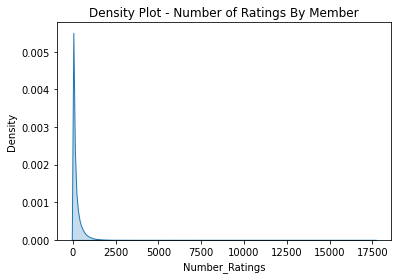

In [ ]:
sns.kdeplot(res_pandas['Number_Ratings'], 
            shade=True).set(title="Density Plot - Number of Ratings By Member")

Predictably, there are some extreme outliers in the data set for power-rater type personalities. It looks more statistically interesting to observe a local distribution for people who rated fewer than 2500 times.

This view is presented below, and predictably we can see that most raters are rating less than 500 movies out of the potential 17,000+ titles in the collection. It will be interesting to see if we can predict at least one of the movies accurately for some subset of consumers in this context. 

[Text(0.5, 1.0, 'Density Plot - Number of Ratings By Member')]

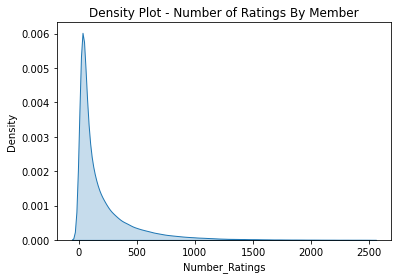

In [ ]:
sns.kdeplot(res_pandas[res_pandas['Number_Ratings'] <2500]['Number_Ratings'], 
            shade=True).set(title="Density Plot - Number of Ratings By Member")

### Ratings system characteristics

In general, a 3 star rating in the insights world is completely inconclusive. The consumer rated the item but neither likes or dislikes it. Netflix's 5 point likert scale rating scheme (textbook social science... and not useful) allows us to see that but the problem statement Netflix provides doesn't seem to be aimed at getting at 1-2 (dislike) vs 4-5 (like). This top two box, bottom two box approach is common in market research as a pre-processing step.

Scenarios that might be interesting to try:

(1) We should look at the impact of transforming ratings to 0 or 1 and removing 3 stars as a pre-processing step. This would be aimed at getting at the extremes of love and hate.

(2) Another scenario that might be interesting to look at is encoding with 1-3 as 0 and 4-5 as 1. Essentially, this approach would try to get at movies that people feel great about as the target. 

(3) What we ultimately did for market basket analysis - which was to only utilize ratings of 4-5 to train a recommender.

The first thing is to examine the relative frequency of the indecisive 3 star rating. How big of a problem is this across all 100 million ratings?


In [ ]:
ratings_res = df.groupby(["Rating"]).count().collect() # spark dataframe operators to collect the relative frequency
ratings_res_pd = pd.DataFrame(ratings_res) # transform aggregated spark outputs into dataframe

In [ ]:
# report the ratings in a tabular form for pre-visualization validation
ratings_res_pd.columns = ["Rating", "Count_of_Ratings"]
ratings_res_pd.sort_values(by = 'Rating', inplace=True) # unordered , for data QA purposes only. No interest in adding any extra computational expense at this stage.
ratings_res_pd

,Rating,Count_of_Ratings
2,1,4617990
4,2,10132080
0,3,28811247
3,4,33750958
1,5,23168232


It seems pretty clear that it's going to be harder to predict the titles that people don't like. Perhaps unsurprisingly, Netflix does not load up their platform with content that people dislike....

Last point on this is that Netflix no longer uses a star rating system at all. The options for rating a movie now are dislike, like, and really like. That should not be particularly surprising given the below distribution of data. The data captured historically might still be comparable if (presumably) 1-2 ratings is a single thumbs down (dislike), a 4 is probably a single thumbs up, and a 5 is probably a two thumbs up. 

It's a very subtle thing, but I would expect it to drive much clearer recommendations.

[Text(0.5, 1.0, 'Rating Level vs Count')]

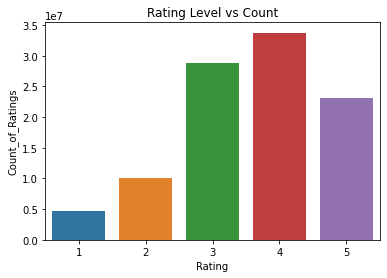

In [ ]:
# barplot to examine the distribution of the likert 1-5 ratings given across the data set
sns.barplot(data=ratings_res_pd, x = "Rating", y='Count_of_Ratings').set(title="Rating Level vs Count")

In [ ]:
# create a spark sql temporary view that can be used to run SQL queries on the data
# some expressions are more direct with SQL - particularly multiple levels of aggregation
df.createOrReplaceTempView("movie_temp_v")

Next - how many people are just unreliable raters and always rate one way or another. Typical pre-processing step in market research is to weed these out.

In [ ]:
# spark SQL - fails to run on Adam's machine for some reason error no 111
results_tmp_noise_raters = spark.sql("""Select User_ID, 
                           count(Movie_ID) as num_movies,
                           count(distinct Rating) as unique_ratings
                           from movie_temp_v 
                           Group by User_ID
                           Having num_movies > 10 and unique_ratings = 1
                           """)

In [ ]:
# collect up the noise movie raters
results_tmp_noise_raters_pandas = pd.DataFrame(results_tmp_noise_raters.collect())
# give the pandas dataframe column names
results_tmp_noise_raters_pandas.columns = ['User_ID', 'num_movies', 'unique_ratings']
# let's look at these cases
results_tmp_noise_raters_pandas

,User_ID,num_movies,unique_ratings
0,1960275,82,1
1,925818,13,1
2,2578683,112,1
3,1453951,16,1
4,861379,54,1
...,...,...,...
771,1935625,16,1
772,498182,24,1
773,2496577,137,1
774,2471826,16,1


In [ ]:
len(results_tmp_noise_raters_pandas) # how many

776

In [ ]:
results_tmp_noise_raters_pandas['num_movies'].sum() #only 52k essentially noise ratings from these consumers

47501

### Title portfolio management effectiveness

Next - what is the distribution of scores for specific titles? Do we still see the same performance bias in the data or are there titles that should have been chopped but weren't?

In [ ]:
# movie scores - are there statistically terrible movies?
results_tmp_bad_movies = spark.sql("""Select Movie_ID, 
                           avg(Rating) as average_movie_rating
                           from movie_temp_v 
                           Group by Movie_ID
                           Having count(Rating) > 15
                           """)

In [ ]:
# collect up the noise movie raters
results_tmp_bad_movies = pd.DataFrame(results_tmp_bad_movies.collect())
#len(results_tmp_bad_movies)

In [ ]:
# rename the columns in the dataframe
results_tmp_bad_movies.columns = ["Movie_ID", "Average_Rating"]
results_tmp_bad_movies.head() # for QA purposes only

,Movie_ID,Average_Rating
0,296,2.913793
1,467,3.563033
2,675,3.201117
3,691,2.989362
4,829,3.187308


The distribution of average movie scores is surprisingly normally distributed when the underlying ratings themselves are clearly skewed. The difference between these two distributions suggests that there are movie portfolio performance management issues that can be optimized. In terms of a recommender, having performance differences between the movies (instead of it being all just about individual consumers not liking a movie) is meaningful. It suggests there are certain movies that are just not very good by anyone's measure.

[Text(0.5, 1.0, 'Distribution of Average Movie Ratings')]

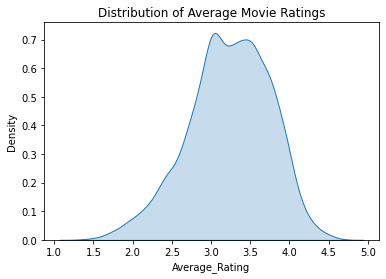

In [ ]:
# density plot of average movie ratings
sns.kdeplot(results_tmp_bad_movies['Average_Rating'], shade=True).set(title='Distribution of Average Movie Ratings')

In [ ]:
# bottom worst movies
twenty_worst_titles = results_tmp_bad_movies.sort_values(by='Average_Rating').head(20)
# join the worst movies together with their titles 
twenty_worst_titles.merge(movie_list, left_on='Movie_ID', right_on='Movie_ID')

,Movie_ID,Average_Rating,Release_Year,Title
0,515,1.287879,2005,Avia Vampire Hunter
1,16487,1.346021,2004,Zodiac Killer
2,11768,1.375610,2004,Alone in a Haunted House
3,17429,1.396761,2005,Vampire Assassins
4,17577,1.400000,2003,Absolution
5,3575,1.400000,2005,The Worst Horror Movie Ever Made
6,8069,1.422222,2002,Ax 'Em
7,2426,1.452381,2004,Dark Harvest 2: The Maize
8,4202,1.487395,2004,Half-Caste
9,1227,1.496241,2005,The Horror Within


Just for fun, let's look at the names of the movies everyone dislikes. Quite a few vampire and undead movies in there. Maybe people don't actually really want to be as scared as they say they do. These types of themes could be useful for a content based filtering approach.

Let's take a look at the best movies now and see where we get to.

Turns out that the top twenty movies are (not surprisingly to either of us) science fiction, comedy, and fantasy. Many of these are most people's favorite shows. Again, there are clear themes here that may be useful for a content based filtering approach.

The caveat is that there are microcosms of viewers who have niche tastes--so, for example, a minority who are fascinated by media that scares them out of their skin may in fact prefer horror-genre movies, even if they are lower rated by the populace as a whole.

In [ ]:
# bottom worst movies
twenty_best_titles = results_tmp_bad_movies.sort_values(by='Average_Rating', ascending=False).head(20)
# join the worst movies together with their titles 
twenty_best_titles.merge(movie_list, left_on='Movie_ID', right_on='Movie_ID')

,Movie_ID,Average_Rating,Release_Year,Title
0,14961,4.723270,2003,Lord of the Rings: The Return of the King: Ext...
1,7230,4.716611,2001,The Lord of the Rings: The Fellowship of the R...
2,7057,4.702611,2002,Lord of the Rings: The Two Towers: Extended Ed...
3,3456,4.670989,2004,Lost: Season 1
4,9864,4.638809,2004,Battlestar Galactica: Season 1
5,15538,4.605021,2004,Fullmetal Alchemist
6,14791,4.600000,2003,Trailer Park Boys: Season 3
7,8964,4.600000,2003,Trailer Park Boys: Season 4
8,10464,4.595506,1995,Tenchi Muyo! Ryo Ohki
9,14550,4.593384,1994,The Shawshank Redemption: Special Edition


## Analysis

Surprisingly, there are content level themes to quality. Sci-fi, comedy, and fantasy are what many people like. We would not have expected to see so much consistency at a theme level for the best ratings. Perhaps content based systems really aren't dead. One potential approach with a data set like this may be to try to parse the titles themselves for themes.

# Fit Models

### ALS: Collaborative Filtering with Matrix Factorization



PySpark has a built-in ALS (Alternating Least Squares) model that leverages collaborative filtering and is widely used. Essentially, what the algorithm does is decompose the sparse ratings matrix into a user matrix and movie matrix, which have lower dimensions. Then, it holds each fixed in turn while optimizing the loss function for the other. Documentation is available here:
https://spark.apache.org/docs/1.4.0/api/java/org/apache/spark/mllib/recommendation/ALS.html

DataCamp has a tutorial (free for us all through this class):
https://campus.datacamp.com/courses/big-data-fundamentals-with-pyspark/machine-learning-with-pyspark-mllib?ex=5

ALS is discussed in-depth in this article here:
https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1

The article is accompanied by a highly detailed jupyter notebook here, for those who may be interested in seeing further demonstrations of ALS usage:
https://github.com/KevinLiao159/MyDataSciencePortfolio/blob/master/movie_recommender/movie_recommendation_using_ALS.ipynb

The below example is a simple, straightforward demonstration of how to run ALS on the Netflix dataset, using the ratings system, a 1-5 score, exactly as provided. Other approaches may replace the ratings with a binary classifier. (See the market basket analysis section, for example.)

In [ ]:
# Data Preparation (can skip if dataframe preparation above was run)

# initiate spark session
spark = SparkSession.builder \
    .config("spark.driver.memory", "15g") \
    .appName('nflx_df') \
    .getOrCreate()
sc = spark.sparkContext
sc.setCheckpointDir('/tmp')

# retrieve the spark dataframe
# Format is 'Movie ID', 'User ID', 'Rating', 'Date'
df = load_spark_dataframe()

Depending on the resources you have available, ALS can take hours to run on the entire data set (because it's enormous). You may wish to take a fraction of it for initial experimentation and parameter fine-tuning. We used 5000 because we were encountering memory challenges with Spark at the time, but you may select a larger fraction.

In [ ]:
df_tiny = df.limit(5000)

In [ ]:
# Convert these to Ratings objects to feed to ALS.
rdd = df.rdd  # To use the tiny subset instead, replace "df" with "df_tiny"
# Rating(user,product,rating)
ratings = rdd.map(lambda line: Rating(int(line[1]), int(line[0]), float(line[2])))
# ratings = ratings.filter(lambda r: r.product != 'Movie ID') - I don't think we need this anymore
# Optional to-do: simplify the rating system, e.g., 0 for did not like (0-3) 
# and 1 for definitively liked (4-5)

# Split into train and test
train_rdd, test_rdd = ratings.randomSplit([0.8,0.2])
test_answers = test_rdd.map(lambda p : p.rating)
test_input = test_rdd.map(lambda p: (p.user, p.product))

The code block immediately below was run with the tiny data set. Note, the MSE values are quite bad because a set of 5000 rows is only enough for a few movies, leaving many, many test user ratings without any other ratings for that user. That leaves ALS trying to make rating predictions with too little data for predictive accuracy, for almost all of them. Using a larger subset would likely help here.

In [ ]:
# ALS Model: Train, Test, Mean Square Error

# Rank: number of latent factors for ALS to use.
# Iterations: API documentation recommends 10-20

# Pulling from here: https://spark.apache.org/docs/2.0.2/ml-collaborative-filtering.html

# Try a few different options for number of features
rank_choices = [10,20,50,100,200]

### This was a run with the tiny dataset!
for rank in rank_choices:
  # Train and run model
  model = ALS.train(train_rdd, rank=rank, iterations=15)
  predictions = model.predictAll(test_input).map(lambda r: ((r[0], r[1]), r[2]))
  ratesAndPreds = test_rdd.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
  # print(ratesAndPreds.take(5)) # debugging
  MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
  print("ALS with " + str(rank) + " features had a MSE of " + str(MSE))

ALS with 10 features had a MSE of 7.110574210684383
ALS with 20 features had a MSE of 7.27753917663297
ALS with 50 features had a MSE of 7.495990279657411
ALS with 100 features had a MSE of 6.082213360628305
ALS with 200 features had a MSE of 5.198912112653238


The code block below, however, ran on the full data set, which is sparse, but still far richer than the tiny sample. Note that the mean squared error is 0.8, so the average rating prediction was off by a bit less than 1 star.

In [ ]:
# Here's a run with the full data set
rank = 200
model = ALS.train(train_rdd, rank=rank, iterations=15)
predictions = model.predictAll(test_input).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = test_rdd.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("ALS with " + str(rank) + " features had a MSE of " + str(MSE))

ALS with 200 features had a MSE of 0.836105839096507


This algorithm took several hours to run, and the session ended while the data scientist was busy with other tasks. Auto-export of the test data and predictions for later is recommended for further analysis, if working on a genuine project. But essentially after this, a simple recommender would filter based on predictions for a given user and return the highest-rated predictions for that user.

In [ ]:
# Given a PySpark RDD, we can filter for, say, rating predictions above a certain value too.
filtered_preds = predictions.filter(lambda row : row[1] > 3)

### Deep Learning Recommender Model

Another idea is to provide recommendations using a deep learning model. For a binary like/no-like case, a binary softmax layer at the end would be used, but this example simply works with the given rating system. The model* is purely collaborative for simplicity's sake, but note that with a deep learning network, the data scientist may consider building a neural net that incorporates content awareness as well. This could mitigate the cold start problem.

(*In the first subsection. See the note in the second section regarding Spark, elephas, and its limitations.)

Resources:

Guide to Spark:
https://spark.apache.org/docs/latest/ml-guide.html

sparkit-learn:
https://stackoverflow.com/questions/30580410/how-to-do-labelencoding-or-categorical-value-in-apache-spark


Articles and examples of deep learning models:

Deep Learning with Netflix by Tsurutama:
https://www.kaggle.com/code/tsurutama/deep-learning-for-netflix-prize-challenge

Medium How-To Guide:
https://medium.com/coinmonks/how-to-implement-a-recommendation-system-with-deep-learning-and-pytorch-2d40476590f9

Example Notebook, Collaborative Filtering:
https://calvinfeng.gitbook.io/machine-learning-notebook/supervised-learning/recommender/neural_collaborative_filtering


Recommenders in Python 101 Article:
https://www.kaggle.com/code/gspmoreira/recommender-systems-in-python-101


Towards Data Science article:
https://towardsdatascience.com/creating-a-hybrid-content-collaborative-movie-recommender-using-deep-learning-cc8b431618af


####Miniature/Without Spark

First, here's our example model used on a subset of the data, without PySpark.

In [ ]:
# Load and work with a small fraction of the data.
df = load_ratings_file()
df = df.iloc[0:10000,:]
df_x= df.filter(['User_ID','Movie_ID'], axis=1)
df_y = df.filter(['Rating'], axis=1)
df_x = df_x.values
df_y = df_y.values

# Split train and test data
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2)

x_train_array = [x_train[:, 0], x_train[:, 1]]


In [ ]:
### EMBEDDING

# Information about the data and the number of dimensions 
# to use in our embedding layers
embedding_dim = 50
user_max = 2649429 # 480189 users total, but we want the max value for the ID
movie_max = 8 # for mini sample

# Borrowed this embedding code and the general idea of 
# how to embed data and feed it into a neural net from here:
# https://www.kaggle.com/code/tsurutama/deep-learning-for-netflix-prize-challenge
user = layers.Input(shape=(1,))
user_embedding = layers.Embedding(user_max+1, embedding_dim, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-6))(user)
user_e_shaped = layers.Reshape((embedding_dim,))(user_embedding)

movie = layers.Input(shape=(1,))
movie_embedding = layers.Embedding(movie_max+1, embedding_dim, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-6))(movie)
movie_e_shaped = layers.Reshape((embedding_dim,))(movie_embedding)

In [ ]:
### NEURAL NETWORK COMPOSITION

# After performing the embedding, take the dot product
# of the two matrices to approximate the user-movie ratings.
# We'll use this to initialize our feed-forward neural network model.
ffnn = layers.Dot(axes=1)([user_e_shaped, movie_e_shaped])
# ReLU is cheaper for earlier layers
ffnn = layers.Dense(400, activation="relu")(ffnn)
# Dropouts help prevent overfitting
ffnn = layers.Dropout(0.2)(ffnn)
ffnn = layers.Dense(200, activation="relu")(ffnn)
ffnn = layers.Dropout(0.2)(ffnn)
# Start using softmax near the end
ffnn = layers.Dense(100, activation="softmax")(ffnn)
ffnn = layers.Dense(1)(ffnn) # Output is the rating

# Compile. Desired metric is how close the estimated rating
# is to the actual rating.
ffnn_model = Model(inputs=[user, movie], outputs=ffnn)

# OPTIONAL: To avoid overfitting, can try monitoring validation loss
#keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

ffnn_model.compile(optimizer='adam',loss='mean_squared_error',
                   metrics=['mean_squared_error'])

In [ ]:
# Here's the run with the data subset.
history = ffnn_model.fit(
    x=x_train_array,
    y=y_train,
    batch_size=50,
    epochs=50,
    verbose="auto",
    callbacks=None,
    validation_split=0.2
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:439: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 132471500 elements. This may consume a large amount of memory.
  num_elements)


128/128 [==============================] - 10s 67ms/step - loss: 10.9101 - mean_squared_error: 10.9100 - val_loss: 9.7117 - val_mean_squared_error: 9.7115
Epoch 2/50
128/128 [==============================] - 8s 65ms/step - loss: 8.7843 - mean_squared_error: 8.7842 - val_loss: 8.2163 - val_mean_squared_error: 8.2163
Epoch 3/50
128/128 [==============================] - 8s 64ms/step - loss: 7.4719 - mean_squared_error: 7.4719 - val_loss: 7.0212 - val_mean_squared_error: 7.0211
Epoch 4/50
128/128 [==============================] - 8s 64ms/step - loss: 6.3889 - mean_squared_error: 6.3889 - val_loss: 6.0179 - val_mean_squared_error: 6.0179
Epoch 5/50
128/128 [==============================] - 8s 65ms/step - loss: 5.4774 - mean_squared_error: 5.4773 - val_loss: 5.1692 - val_mean_squared_error: 5.1692
Epoch 6/50
128/128 [==============================] - 8s 65ms/step - loss: 4.7093 - mean_squared_error: 4.7093 - val_loss: 4.4550 - val_mean_squared_error: 4.4549
Epoch 7/50
128/128 [==========

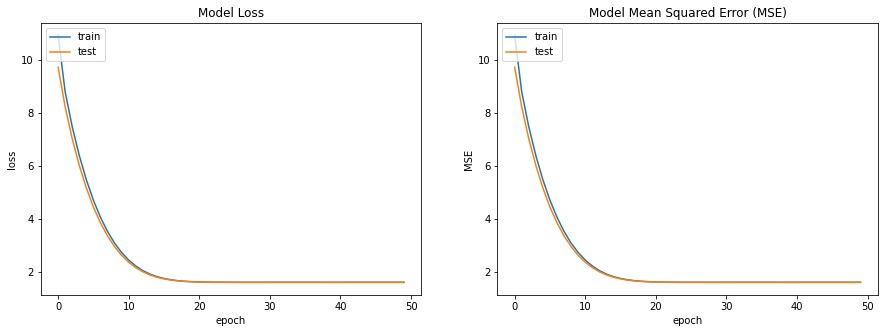

In [ ]:
# Take the results and plot them, let's see how we did
plot_training_history(history)

As the graphs demonstrate, the mean squared error is not good at all with the sparse subset, though not quite as bad as ALS. In this case, we trained on 10000 ratings instead of 5000, so that might explain why the neural net's tiny-dataset MSE improved over ALS's tiny-dataset MSE. However, it may also be the nature of the model.

####Deep RL With Spark

Now for an incredibly naïve example that uses Spark and the full data set. Originally, the plan had been to leverage the libraries with the same neural network and the same embedding strategy for the data. However, the approach we found for parallelizing deep learning uses elephas to synthesize pyspark with Keras, and we discovered that elephas does not support multi-input models. Reference:

https://github.com/maxpumperla/elephas/issues/143


Due to time and library constraints, usage of elephas and spark with Keras is demonstrated with the dummy deep RL model shown below. Its output is probably garbage, but the example illustrates the basics of the library API calls and the format for the input. To leverage these libraries and a neural net properly, a better pipeline is required.

In [ ]:
spark = SparkSession.builder\
        .master("local")\
        .config('spark.driver.memory','15g')\
        .appName("nflx_df")\
        .config('spark.ui.port', '4050')\
        .config('spark.executor.memory','12g')\
        .getOrCreate()

spark.sparkContext.setCheckpointDir('/tmp')
sc = spark.sparkContext
df = load_spark_dataframe()

In [ ]:
rdd = df.rdd
ratings = rdd.map(lambda line: ((int(line[1]), int(line[0])), float(line[2])))

# Split into train and test
train_rdd, test_rdd = ratings.randomSplit([0.8,0.2])
test_answers = test_rdd.map(lambda p : p.rating)
test_input = test_rdd.map(lambda p: (p.user, p.product))
train_rdd.take(5)

# note the format. it's an array of pairs: (feature_set,y-value)

[((1488844, 1), 3.0),
 ((822109, 1), 5.0),
 ((885013, 1), 4.0),
 ((30878, 1), 4.0),
 ((823519, 1), 3.0)]

In [ ]:
# A very, very stupid model. Filler example because the two-input model
# does not play nicely with elephas. A marginally less stupid model would
# one-hot encode the user and movie ID data. A truly not-stupid approach
# would create and combine embeddings for the user and movie ID data into a single
# input before feeding it to the model, somehow.
ffnn = Sequential()
ffnn.add(layers.Dense(1000, input_dim=2, activation='relu'))
# Dropouts help prevent overfitting
ffnn.add(layers.Dropout(0.2))
ffnn.add(layers.Dense(200, activation="relu"))
ffnn.add(layers.Dropout(0.2))
# Start using softmax near the end
ffnn.add(layers.Dense(100, activation="softmax"))
ffnn.add(layers.Dense(1))

ffnn_model = ffnn
ffnn_model.compile(optimizer='adam',loss='mean_squared_error',
                   metrics=['mean_squared_error'])

In [ ]:
# Create spark model from the keras model.
spark_model = SparkModel(ffnn_model, frequency='epoch', mode='asynchronous')

history = spark_model.fit(train_rdd, epochs=100, batch_size=100, verbose="auto", validation_split = 0.2)

>>> Fit model
 * Serving Flask app "elephas.parameter.server" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://172.28.0.2:4000/ (Press CTRL+C to quit)


>>> Initialize workers
>>> Distribute load


INFO:werkzeug:172.28.0.2 - - [28/Nov/2022 04:17:35] "GET /parameters HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.2 - - [28/Nov/2022 04:22:29] "POST /update HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.2 - - [28/Nov/2022 04:22:29] "GET /parameters HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.2 - - [28/Nov/2022 04:27:51] "POST /update HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.2 - - [28/Nov/2022 04:27:51] "GET /parameters HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.2 - - [28/Nov/2022 04:32:47] "POST /update HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.2 - - [28/Nov/2022 04:32:47] "GET /parameters HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.2 - - [28/Nov/2022 04:38:09] "POST /update HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.2 - - [28/Nov/2022 04:38:09] "GET /parameters HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.2 - - [28/Nov/2022 04:43:31] "POST /update HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.2 - - [28/Nov/2022 04:43:31] "GET /parameters HTTP/1.1" 200 -
INFO:werkzeug:172.28.0.2 - - [28/Nov/2022 04:48:18] "POST /update HTTP/1.1" 200 

In [ ]:
# The above took so long to run that I had issues getting it to complete.
# So note that deep learning models can be computationally expensive! Here is
# the terribly naive model with a much smaller dataset and fewer epochs, just
# to see it complete

spark = SparkSession.builder\
        .master("local")\
        .config('spark.driver.memory','15g')\
        .appName("nflx_df")\
        .config('spark.ui.port', '4050')\
        .config('spark.executor.memory','12g')\
        .getOrCreate()

spark.sparkContext.setCheckpointDir('/tmp')
sc = spark.sparkContext
df = load_spark_dataframe()
df = df.limit(100000)

rdd = df.rdd
ratings = rdd.map(lambda line: ((int(line[1]), int(line[0])), float(line[2])))

ffnn = Sequential()
ffnn.add(layers.Dense(1000, input_dim=2, activation='relu'))
ffnn.add(layers.Dropout(0.2))
ffnn.add(layers.Dense(200, activation="relu"))
ffnn.add(layers.Dropout(0.2))
ffnn.add(layers.Dense(100, activation="softmax"))
ffnn.add(layers.Dense(1))

ffnn_model = ffnn
ffnn_model.compile(optimizer='adam',loss='mean_squared_error',
                   metrics=['mean_squared_error'])

# Create spark model from the keras model.
# We do synchronous here to collect history results.
# For high performance/parallelization, use asynchronous.
spark_model = SparkModel(ffnn_model, frequency='epoch', mode='synchronous') 
spark_model.fit(ratings, epochs=20, batch_size=100, verbose="auto", validation_split = 0.2)

>>> Fit model
>>> Synchronous training complete.


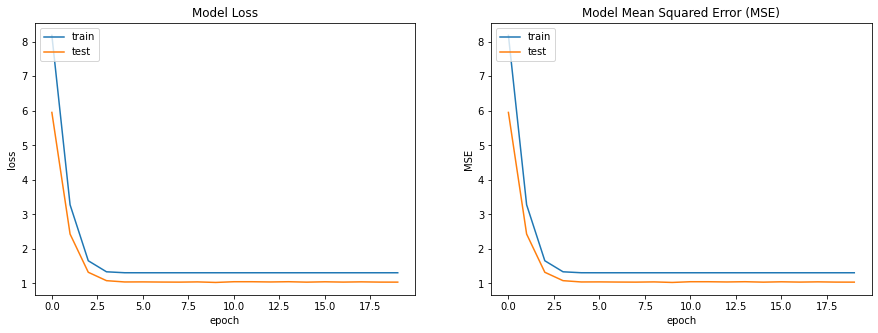

In [ ]:
# Let's see how we did...
history = spark_model.training_histories[0]
plot_training_history_2(history)

At first glance, well... it could have been worse. It's possible to be only a star or a star and a half off on average by predicting the mean consistently, though. For actual projects, ensure you check what the model is doing (i.e. is it predicting the mean repeatedly or is it actually attempting to predict various values).

## Market Basket Analysis - Alternative Approach to Recommenders

<Adam to apply a priori to this data set>




https://spark.apache.org/docs/2.2.0/ml-frequent-pattern-mining.html 

The key here according to the Pyspark documentation is to get the data arranged into a dataframe consisting of two columns. The first column would be the user ID and the second column would be a list of movies selected.

In our example, the movies selected happen to be on a ratings scale. With a priori, the way to think about this is the original motivation of the algorithm - which was "market basket analysis" of basically discrete choices to buy or not buy a product in a supermarket. 

With our ratings data, we know that some of the ratings are very high, and some are quite low , and some are basically totally neutral. A reasonable transformation of the data would be to try to evaluate to recommendations based on high ratings only. So given that a user scores a movie a 4 or 5, encoding the data as having been selected. 

Frankly, I know that it's common practice to do a recommender system to predict how someone would rate something, but there's limited value in figuring out what we should NOT present to a user. We want to know what we should recommend - so let's just do that.

The most expedient way to do this is to employ a select statement to remove all of the ratings that are less than 3. Then, we can simply run a grouping statement to roll up all of the movie IDs that are left into a user ID as a list, thereby conforming to the requirements of the algorithm's target format. An added benefit of this treatment of the data is that it inherently eliminates large numbers of unwanted records while simultaneously giving us the capability to achieve precision recommendations based on all of the remaining titles to find a good one for that specific person.

In industry, Adam has found this type of treatment of the data to be not only practical and expedient from a computational perspective, but also capable of identifying novel insights that other types of methodologies tend to miss. He thinks that the reason for this is the ability of the algorithm to pay attention to local distributions of data vs giving only the most likely answers - thereby leading to deeper insights from revealed preferences oriented data.

Lastly, by comparing the set of what a user has seen to what they haven't, we can also efficiently provide recommendations that are actually new - vs only recommending movies they've already seen. Stepping back for a minute, and thinking about the problem of overfitting as well, if most modelers are working with the entire 100 million rows of recommendations , they're weighting their recommendations to 40 percent based on movies people don't actually want. With each movie being a feature, that could be a massive overfitting problem.

In [ ]:
#https://www.educba.com/pyspark-filter/
#a.filter(a.Name == "JOHN").show()

# spark SQL - fails to run on Adam's machine for some reason error no 111
df_fpm = df.filter(df.Rating >= 4)

In [ ]:
print((df_fpm.count(), len(df_fpm.columns)))

(56919190, 4)


In [ ]:
df_fpm.show()

+--------+-------+------+----------+
|Movie_ID|User_ID|Rating|      Date|
+--------+-------+------+----------+
|       1| 822109|     5|2005-05-13|
|       1| 885013|     4|2005-10-19|
|       1|  30878|     4|2005-12-26|
|       1| 124105|     4|2004-08-05|
|       1|1842128|     4|2004-05-09|
|       1|1503895|     4|2005-05-19|
|       1|2207774|     5|2005-06-06|
|       1| 543865|     4|2004-05-28|
|       1|1209119|     4|2004-03-23|
|       1| 804919|     4|2004-06-10|
|       1|1711859|     4|2005-05-08|
|       1| 372233|     5|2005-11-23|
|       1| 558634|     4|2004-12-14|
|       1|2165002|     4|2004-04-06|
|       1|1227322|     4|2004-02-06|
|       1| 427928|     4|2004-02-26|
|       1| 814701|     5|2005-09-29|
|       1| 808731|     4|2005-10-31|
|       1| 662870|     5|2005-08-24|
|       1| 337541|     5|2005-03-23|
+--------+-------+------+----------+
only showing top 20 rows



In [ ]:
# Needed to look up how to do this in Python. 
# Article shows how to do this with 
# https://stackoverflow.com/questions/59023771/python-equivalent-to-dplyrs-summarize 

# turns out it wasn't exactly the same, but there's a function here to show how to do that
# https://stackoverflow.com/questions/71518391/pyspark-dataframe-groupby-into-list-of-values
#df_rearrange = df.groupby(User_ID).agg({'product_name':list})

from pyspark.sql.functions import *
df_fpm_in = df.groupBy( col("User_ID")).agg(collect_list(col("Movie_ID"))   )

In [ ]:
df_fpm_in.show()

+-------+----------------------+
|User_ID|collect_list(Movie_ID)|
+-------+----------------------+
|1000131|  [872, 1220, 1798,...|
|1000176|  [30, 191, 295, 33...|
|1000240|  [1145, 1406, 1542...|
|1000264|  [30, 1046, 1110, ...|
|1000569|  [148, 191, 197, 2...|
|1000599|  [758, 759, 846, 1...|
|1000634|  [16, 33, 46, 58, ...|
|1000828|         [5239, 14135]|
|1000869|  [313, 571, 1043, ...|
|1000888|  [4570, 4883, 5226...|
|1001012|  [167, 443, 1220, ...|
|1001129|  [8, 9, 14, 16, 17...|
|1001154|  [30, 156, 223, 29...|
|1001167|  [8, 18, 143, 165,...|
|1001330|  [175, 197, 313, 4...|
|1001370|  [1060, 2338, 2612...|
| 100140|  [1145, 4144, 4996...|
|1001416|  [1406, 1409, 3441...|
|1001525|  [571, 586, 703, 1...|
| 100172|  [2152, 2200, 2209...|
+-------+----------------------+
only showing top 20 rows



In [ ]:
df_fpm_in.describe

<bound method DataFrame.describe of DataFrame[User_ID: string, collect_list(Movie_ID): array<string>]>

In [ ]:
# Column names in dataframe

# Create the spark dataframe
df_fpm_in_ = df_fpm_in.withColumnRenamed('collect_list(Movie_ID)',"Movies").sample(.10, 12345)
df_fpm_in_.printSchema()


root
 |-- User_ID: string (nullable = true)
 |-- Movies: array (nullable = false)
 |    |-- element: string (containsNull = false)



In [ ]:
print((df_fpm_in_.count(), len(df_fpm_in_.columns)))

(47946, 2)


In [ ]:
df_fpm_in_.show()

+-------+--------------------+
|User_ID|              Movies|
+-------+--------------------+
|1000176|[30, 191, 295, 33...|
|1003202|[1428, 2333, 2724...|
|1009134|      [10901, 14215]|
|1024757|[1962, 1110, 1145...|
| 102570|[422, 1307, 2128,...|
|1042307|[197, 313, 579, 1...|
|1056049| [3875, 8782, 12738]|
|1076082|[1145, 1307, 2612...|
|1086104|[2809, 3689, 3864...|
|1092458|[143, 550, 798, 2...|
|1119319|[152, 607, 1145, ...|
|1127452|[886, 30, 896, 26...|
|1134137|[1110, 3079, 4547...|
|1138626|[924, 6, 985, 8, ...|
|1142666|[175, 571, 1962, ...|
|  11965|[1650, 4577, 4656...|
|1217159|[1428, 1905, 3925...|
|1224819|[111, 1046, 191, ...|
|1232458|[223, 494, 571, 1...|
|1238177|[607, 1145, 2913,...|
+-------+--------------------+
only showing top 20 rows



Code gist for a priori from PySpark documentation.

In [ ]:
#This is a really good demo on how to transform the data very efficiently with only a few lines of code for our type of use case
#https://www.linkedin.com/pulse/association-rules-using-fpgrowth-spark-mllib-through-sparklyr-lam/

# target format is two columns
# column 1 is the User ID for us
# column two is a list of items
# https://spark.apache.org/docs/2.2.0/ml-frequent-pattern-mining.html

from pyspark.ml.fpm import FPGrowth

# from the code gist above
fpGrowth = FPGrowth(itemsCol="Movies", minSupport=0.15, minConfidence=0.5)
model = fpGrowth.fit(df_fpm_in_)

Have to rearrange the data a bit to fit the frequent itemset algo formatting requirements. 

In [ ]:
# Display frequent itemsets.
model.freqItemsets.show()

+--------------+-----+
|         items| freq|
+--------------+-----+
|        [3320]| 7360|
|       [17441]| 7266|
|        [9645]| 7828|
|        [7233]| 8314|
|       [14928]| 9630|
| [14928, 1905]| 7239|
|[14928, 11283]| 7680|
|       [16452]| 8877|
|       [14670]| 7632|
|       [15425]| 8160|
|         [607]|10062|
|   [607, 7624]| 7435|
|   [607, 6287]| 7469|
|   [607, 1905]| 7771|
|  [607, 12918]| 7360|
|  [607, 12470]| 7215|
|  [607, 15124]| 8114|
|  [607, 16879]| 7216|
|  [607, 11283]| 7712|
|   [607, 5317]| 7873|
+--------------+-----+
only showing top 20 rows



In [ ]:
# Display generated association rules.
model.associationRules.show()

+-------------------+----------+------------------+------------------+-------------------+
|         antecedent|consequent|        confidence|              lift|            support|
+-------------------+----------+------------------+------------------+-------------------+
|[11521, 4432, 1905]|    [2452]|0.9061214312429872|2.9047481192646742|0.15116786954803552|
|     [16954, 11283]|    [2452]|0.7382864112206525| 2.366720387056791|0.15108467314212026|
|     [16954, 11283]|   [13728]|0.7621709523325542|2.4364639107178774|0.15597246198964204|
|     [16954, 11283]|   [15107]|0.7362536843175119| 2.211843344682683|0.15066869111254394|
|     [16954, 11283]|   [16377]|0.7346275027949994| 1.956578534615598|0.15033590548888287|
|     [16954, 11283]|    [4306]| 0.765321679032422|2.4274905004749847|0.15661723413548534|
|     [16954, 11283]|    [1905]|0.8223396686655148|2.0475022749751055| 0.1682855300651012|
|     [16954, 11283]|   [15124]| 0.790324219941051|1.7667735235293527|0.16173381309927412|

In [ ]:
# export association rules 
recs_out = pd.DataFrame(model.associationRules.collect())
recs_out.to_csv("recommendations_rules.csv")

In [ ]:
# transform examines the input items against all the association rules and summarize the
# consequents as prediction
model.transform(df_fpm_in_).show()

+-------+--------------------+--------------------+
|User_ID|              Movies|          prediction|
+-------+--------------------+--------------------+
|1000176|[30, 191, 295, 33...|[2452, 13728, 151...|
|1001012|[167, 443, 1220, ...|[6037, 14454, 143...|
| 100172|[2152, 2200, 2209...|[15124, 11283, 76...|
|1002080|             [15700]|                  []|
| 100213|[30, 79, 80, 175,...|[10042, 14691, 12...|
|1002501|[30, 143, 175, 19...|[16377, 4306, 531...|
|1002783|[1719, 1865, 2407...|[1905, 15205, 121...|
|1003202|[1428, 2333, 2724...|[1905, 15205, 286...|
|1004316|[61, 111, 167, 20...|[15107, 4306, 190...|
|1004565|[83, 104, 189, 25...|[6972, 16242, 190...|
| 100553|[1377, 1602, 1983...|[12155, 13081, 86...|
| 100576|[191, 468, 1138, ...|[14240, 6037, 151...|
|1006269|[26, 28, 30, 77, ...|[12672, 6692, 134...|
|1006584|[33, 175, 187, 19...|[2452, 16377, 151...|
|1008348|[312, 571, 1470, ...|[12155, 13081, 86...|
|1009134|      [10901, 14215]|                  []|
| 100924|[57

In [ ]:
# get predictions into a pandas dataframe
preds_out = pd.DataFrame(model.transform(df_fpm_in_).collect())

In [ ]:
# export those predictions to a csv
preds_out.to_csv("predictions_by_user.csv")

In [ ]:
# read back in to present and work on later
user_level_predictions_ = pd.read_csv("predictions_by_user.csv")
user_level_predictions_.columns = ["Row","User_ID","Movies","Recommendations"]

In [ ]:
user_level_predictions_

,Row,User_ID,Movies,Recommendations
0,0,1000176,"['851', '30', '191', '295', '330', '607', '190...","['15107', '13728', '2452', '11521', '5317', '2..."
1,1,1003202,"['1428', '2885', '2333', '2724', '3408', '3825...","['2372', '15205', '1905', '5496', '6134', '171..."
2,2,1009134,"['10901', '14215']",[]
3,3,1024757,"['1962', '1110', '1145', '1307', '1470', '1645...","['1905', '15205', '5496', '6037', '16242', '11..."
4,4,102570,"['422', '1307', '2128', '2152', '2200', '2612'...","['4996', '13462', '15107', '13728', '6287', '1..."
...,...,...,...,...
2510,2510,423646,"['1075', '138', '209', '270', '345', '413', '4...","['15107', '5317', '16384', '9340', '3860', '60..."
2511,2511,486320,"['473', '1865', '2913', '2342', '2391', '2613'...","['1905', '3860', '1962', '571', '12232']"
2512,2512,891361,"['1145', '1865', '4123', '5320', '8782', '1128...","['3624', '14691', '11064', '15107', '16377', '..."
2513,2513,925816,"['551', '571', '2122', '2152', '3491', '5317',...","['4996', '16377', '7624', '12911', '6972', '72..."


In the future, Adam will likely work on a method to feed this with a spark dataframe instead of a pandas dataframe.

https://github.com/lispsil/python-arulesviz

# Summary Report

In general, the main challenge we had to overcome to do this demonstration is to work with the necessary big data technologies required to work with a data set as large as the Netflix recommendations data set. At 100 million rows, the usual in memory techniques did not work. Moreover, recommendations are inherently also *high dimension* sparse matrix type problems ; that 100 million rows was really a sparse matrix of 100 million rows X 17k columns. To work with this data we learned some rudimentary spark techniques.

Once we did get our stack to work, we very quickly began to draw insights from the entire asset instead of potentially sample level insights gained from down sampling our data. It only took a quick examination of the data to determine that Netflix's movie portfolio was not very well optimized. While the typical rating skewed neutral to favorable, the distribution of average movie ratings itself was more or less normally distributed. In general, this pointed to additional opportunity to optimize at the title level. 

The typical approaches for this data set revolve around responding to the likert scale that the data is presented on. We also did this with alternate least squares (ALS) and a neural net, but we also chose to take a somewhat different approach to the problem in which we sought to create recommendations based on favorable ratings (4-5 on the likert scale). 

Doing this led us to train recommenders using market basket analysis. Very much analagous to selecting 50 or so items in a grocery store containing perhaps 100k SKUs, a recommender trained to identify frequent favorite itemsets will capture recommendations based on a local distribution of data. To be useful, recommenders by definition should identify recommendations for a consumer that they have not seen before but which they would have a high propensity to like. In the original Netflix prize, contestants were asked (oddly) to predict all of the movie ratings for a basket of consumers. It's not that surprising that Netflix never took that system into production - why would anyone want an algorithm that's trained to be proficient at predicting ratings for consumers that they have already watched? Moreover, that approach also invests substantial effort in predicting ratings for movies that people don't even like. 

Overall, recommenders should play an important role in the consumer ecosystem. By nudging consumers in the right direction, brands can save their consumers time and effort and increase sales. However, while each recommender system can cross validate and test well on old data, the ultimate test of truth is experimentation. Netflix is famous for running experiments. While there are a lot of interesting debates about "statistics" vs "data science" right now, Netflix is a great example of where these two worlds meet. We believe the right way to think about these types of algorithms is that the techniques provide useful systematic treatment of the data at scale while statistics can be used to perform more controlled testing. Randomly sampling consumers into different groups and presenting different recommendations based on different techniques can create compelling and verifiable business value.


Netflix presenting on its technology and approach at a data science conference: 
https://youtu.be/II8GlmbDg9M 


Note as well that, broadly speaking, we must be mindful of the potential biases and limitations of recommenders--popularity bias, myopia, and the like--and the ethical ramifications of letting those biases creep into marketing and media-sharing platforms. Because of this, it is important to consider the recommenders we use carefully. Tools such as PySpark can help us try out different approaches more efficiently and effectively.